<a href="https://colab.research.google.com/github/pexize/-Criando-um-Sistema-de-Reconhecimento-Facial-do-Zero/blob/main/recomenda%C3%A7%C3%A3o_por_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Instalar dependências
!pip install torch torchvision pillow scikit-learn matplotlib requests googletrans==4.0.0-rc1

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import models, transforms
import requests
from google.colab import files
from googletrans import Translator

In [16]:
# Fazer upload de imagens manualmente
uploaded = files.upload()

# Listar as imagens carregadas
image_paths = list(uploaded.keys())
print("Imagens carregadas:", image_paths)

Saving Captura de tela 2025-02-10 151240.png to Captura de tela 2025-02-10 151240.png
Imagens carregadas: ['Captura de tela 2025-02-10 151240.png']


In [17]:
# Definir transformações para pré-processamento
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar para 224x224
    transforms.ToTensor(),          # Converter para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar
])

# Função para carregar e pré-processar imagens
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Adicionar dimensão de batch
    return img_tensor

In [18]:
# Carregar modelo ResNet50 pré-treinado
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()  # Modo de avaliação
# Carregar o mapeamento completo do ImageNet a partir do arquivo class.txt // https://www.kaggle.com/datasets/skyap79/imagenet-classes/data  <--para baixar
def load_imagenet_classes(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        return eval(content)  # Converter o texto em um dicionário

# Caminho para o arquivo class.txt
class_file_path = "./class.txt"  # Certifique-se de que o arquivo está no diretório atual

# Carregar o mapeamento
IMAGENET_CLASSES = load_imagenet_classes(class_file_path)

# Função para extrair características e prever classe
def extract_features_and_predict(image_tensor):
    with torch.no_grad():  # Desativar cálculo de gradientes
        logits = model(image_tensor)  # Saída final do modelo
        probabilities = torch.nn.functional.softmax(logits, dim=1)  # Probabilidades
        predicted_class = torch.argmax(probabilities, dim=1).item()  # Classe prevista
        return predicted_class

# Extrair características e gerar palavra-chave
query_image_index = 0  # Índice da imagem de consulta
img_tensor = load_and_preprocess_image(image_paths[query_image_index])
predicted_class = extract_features_and_predict(img_tensor)

# Obter a palavra-chave com base na classe prevista
keyword = IMAGENET_CLASSES.get(predicted_class, "produto desconhecido")

# Traduzir a palavra-chave para o português
translator = Translator()
translated_keyword = translator.translate(keyword, src='en', dest='pt').text

print(f"Palavra-chave gerada (inglês): {keyword}")
print(f"Palavra-chave traduzida (português): {translated_keyword}")

Palavra-chave gerada (inglês): loudspeaker, speaker, speaker unit, loudspeaker system, speaker system
Palavra-chave traduzida (português): alto -falante, alto -falante, unidade de alto -falante, sistema de alto -falante, sistema de alto -falante


In [19]:
#!wget https://filebin.net/suc5hzv8jh7xufty/imagenet1000_clsidx_to_labels.txt
!ls

'Captura de tela 2025-02-06 082134.png'  'Jeans (1).jpg'
'Captura de tela 2025-02-06 100444.png'   sample_data
'Captura de tela 2025-02-06 115940.png'  'WhatsApp Image 2025-02-10 at 15.16.16 (1) (1).jpeg'
'Captura de tela 2025-02-10 151240.png'  'WhatsApp Image 2025-02-10 at 15.16.16 (1).jpeg'
 class.txt


In [20]:
# Configurar a chave da API do SerpAPI
SERPAPI_API_KEY = "abc"  # Substitua pela sua chave real

# Função para buscar produtos no Google Shopping
def search_google_shopping(keyword):
    url = "https://serpapi.com/search"
    params = {
        "engine": "google_shopping",
        "q": keyword,
        "api_key": SERPAPI_API_KEY
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Erro ao buscar produtos: {response.status_code}")
        print(response.text)  # Imprime o erro detalhado
        return None

# Buscar produtos relacionados usando a palavra-chave traduzida
shopping_results = search_google_shopping(translated_keyword)

# Mostrar produtos encontrados
if shopping_results and "shopping_results" in shopping_results:
    print("Produtos Relacionados:")
    for product in shopping_results["shopping_results"][:5]:  # Mostrar apenas 5 produtos
        title = product.get("title", "Título não disponível")
        price = product.get("price", "Preço não disponível")

        # Tentar obter o link de diferentes campos
        link = product.get("link", None) or product.get("product_link", None) or product.get("url", "Link não disponível")

        print(f"Título: {title}")
        print(f"Preço: {price}")
        print(f"Link: {link}")
        print("-" * 50)
else:
    print("Nenhum produto encontrado.")

Produtos Relacionados:
Título: Alto TX308 350-Watt 8-Inch 2-Way Powered PA System Loudspeaker
Preço: $119.00
Link: https://www.google.com/shopping/product/1?gl=us&prds=pid:12974619723836059624
--------------------------------------------------
Título: Alto Professional TX310 Powered Speaker
Preço: $149.00
Link: https://www.google.com/shopping/product/123871760476773400?gl=us
--------------------------------------------------
Título: Biamp Desono EX-S10-UB Speaker
Preço: $540.00
Link: https://www.google.com/shopping/product/5049434425529674472?gl=us
--------------------------------------------------
Título: Algo 8507 IP Horn Array Speaker 8507 (SIP)
Preço: $4,250.00
Link: https://www.google.com/shopping/product/1?gl=us&prds=pid:16805690421956215815
--------------------------------------------------
Título: FL-18S28X4S Passive Line Array Speaker System
Preço: $5,999.99
Link: https://www.google.com/shopping/product/10210189174062764979?gl=us
-----------------------------------------------

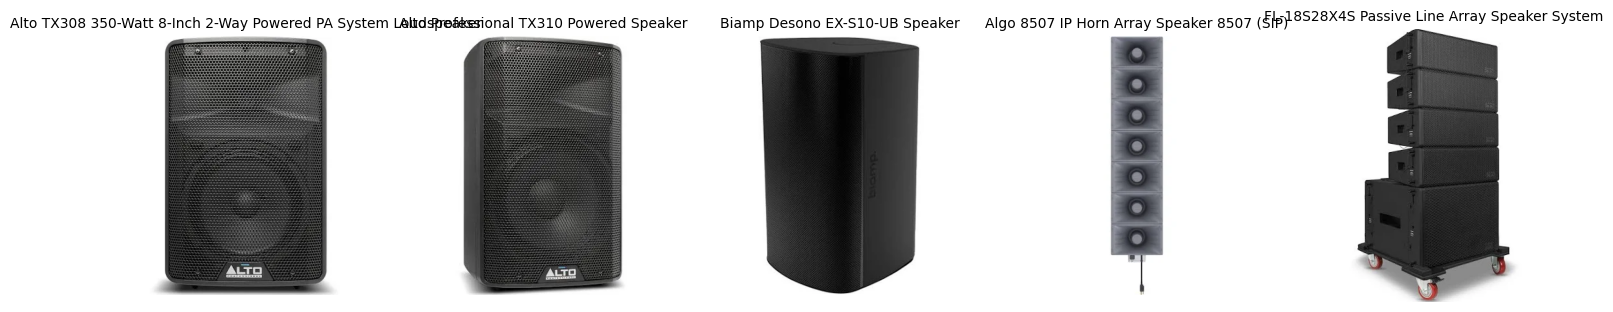

In [21]:
from PIL import Image
import requests
from io import BytesIO

# Função para exibir imagens
def display_images_from_urls(image_urls, titles):
    fig, axes = plt.subplots(1, len(image_urls), figsize=(15, 5))
    if len(image_urls) == 1:
        axes = [axes]  # Garantir que axes seja uma lista para um único item

    for i, (url, title) in enumerate(zip(image_urls, titles)):
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(title, fontsize=10)
        except Exception as e:
            print(f"Erro ao carregar imagem {title}: {e}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar imagens dos produtos
if shopping_results and "shopping_results" in shopping_results:
    image_urls = []
    titles = []
    for product in shopping_results["shopping_results"][:5]:  # Mostrar apenas 5 produtos
        title = product.get("title", "Título não disponível")
        thumbnail = product.get("thumbnail", None)

        if thumbnail:  # Apenas produtos com imagens
            image_urls.append(thumbnail)
            titles.append(title)

    if image_urls:
        display_images_from_urls(image_urls, titles)
    else:
        print("Nenhuma imagem disponível para os produtos encontrados.")
else:
    print("Nenhum produto encontrado.")

In [ ]:
print(keyword)